### Full DistilBERT

In [ ]:
!pip install torch transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from datasets import load_dataset, Dataset
from transformers import (
    DistilBertConfig,
    DistilBertTokenizer,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SetFit/sst5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/171k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [ ]:
# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to tokenize the dataset
def encode(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Apply the tokenizer to each split of the dataset
train_dataset = dataset['train'].map(encode, batched=True)
val_dataset = dataset['validation'].map(encode, batched=True)
test_dataset = dataset['test'].map(encode, batched=True)

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [ ]:
# Example values
total_examples = len(train_dataset)  # Total number of training examples
batch_size = 16  # As per your training arguments

steps_per_epoch = total_examples // batch_size

In [ ]:
# Load the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=600,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=steps_per_epoch,  # Ensures it logs at the end of each epoch
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    learning_rate=3e-5,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.365300,1.186539,0.478656
2,1.081700,1.162465,0.471390
3,0.828000,1.281057,0.485922
4,0.581700,1.502795,0.480472
5,0.398100,1.716921,0.505904
6,0.259800,2.160895,0.476839
7,0.184900,2.521051,0.483197
8,0.134600,2.934481,0.490463
9,0.100300,3.254876,0.481381
10,0.079700,3.548029,0.485014


TrainOutput(global_step=8010, training_loss=0.344442800219437, metrics={'train_runtime': 1658.691, 'train_samples_per_second': 77.266, 'train_steps_per_second': 4.829, 'total_flos': 4244482523750400.0, 'train_loss': 0.344442800219437, 'epoch': 15.0})

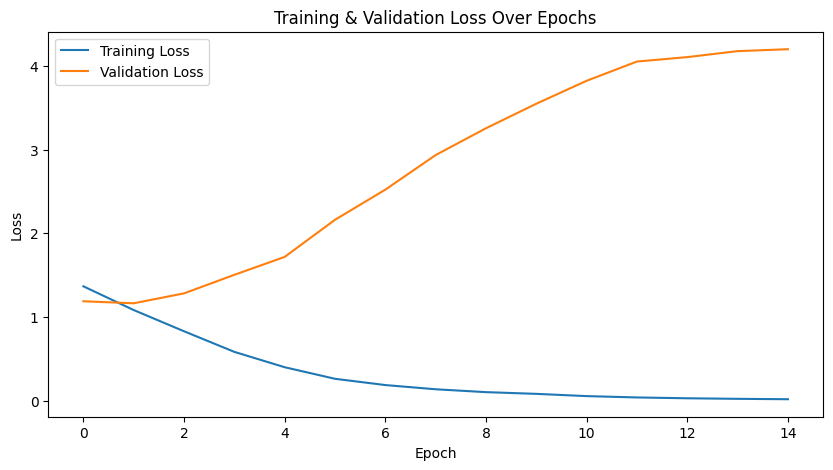

In [ ]:
import matplotlib.pyplot as plt

# Access and plot training and validation losses
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Print evaluation results
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 1.108428955078125, 'eval_accuracy': 0.5031674208144796, 'eval_runtime': 7.795, 'eval_samples_per_second': 283.514, 'eval_steps_per_second': 4.49, 'epoch': 15.0}


### DistilBERT with smaller model configuration

In [ ]:
# Example values
total_examples = len(train_dataset)  # Total number of training examples
batch_size = 16  # As per your training arguments

steps_per_epoch = total_examples // batch_size

In [ ]:
# Create a smaller model configuration
config = DistilBertConfig(
    n_layers=2,  # Reduced from 6 to 2 layers
    dim=256,  # Reduced from 768 to 256
    hidden_dim=1024,  # Adjust intermediately fully connected layer size
    n_heads=4,  # Reduced from 12 to 4 attention heads
    #dropout=0.1,
    attention_dropout=0.1,
    num_labels=5
)

# Initialize the model with the custom configuration
model = DistilBertForSequenceClassification(config)

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=600,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=steps_per_epoch,  # Ensures it logs at the end of each epoch
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    learning_rate=3e-5,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.585000,1.575205,0.262489
2,1.568000,1.566780,0.253406
3,1.481900,1.421421,0.377838
4,1.287400,1.381397,0.390554
5,1.162600,1.417807,0.400545
6,1.081300,1.467333,0.412352
7,1.012600,1.524861,0.400545
8,0.953000,1.592304,0.397820
9,0.903600,1.639885,0.398728
10,0.862300,1.714327,0.390554


TrainOutput(global_step=8010, training_loss=1.0530347883626912, metrics={'train_runtime': 153.9193, 'train_samples_per_second': 832.644, 'train_steps_per_second': 52.04, 'total_flos': 162119799889920.0, 'train_loss': 1.0530347883626912, 'epoch': 15.0})

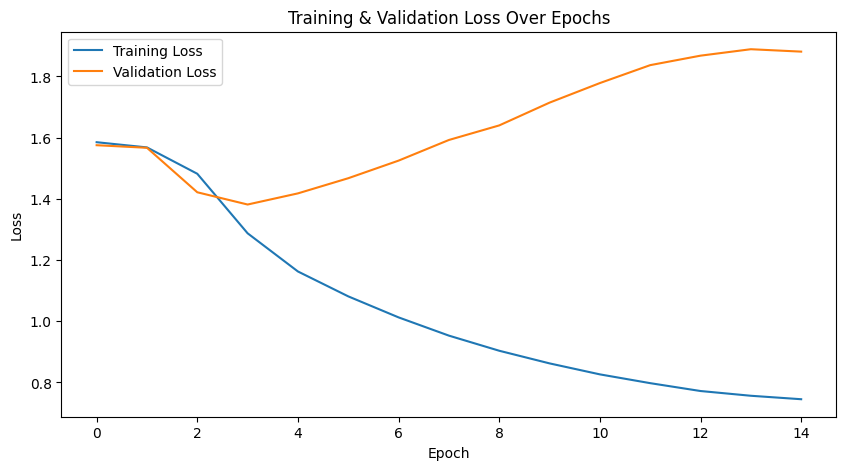

In [ ]:
import matplotlib.pyplot as plt

# Access and plot training and validation losses
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Print evaluation results
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 1.3810040950775146, 'eval_accuracy': 0.39819004524886875, 'eval_runtime': 0.7526, 'eval_samples_per_second': 2936.467, 'eval_steps_per_second': 46.505, 'epoch': 15.0}


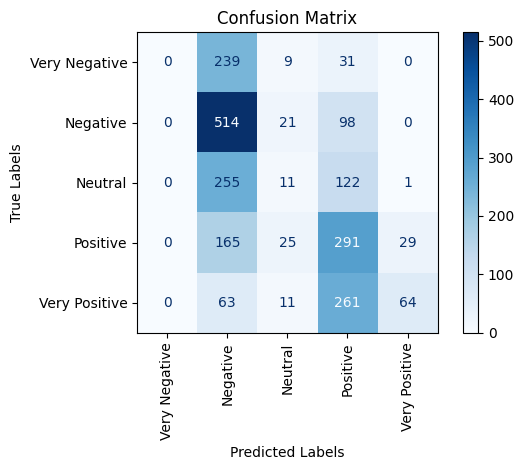

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=1)  # Get the predicted class
labels = predictions.label_ids                  # True labels

# Define label names for SST-5
label_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

# Compute the confusion matrix
cm = confusion_matrix(labels, preds)

# Create a display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

# Show the plot
plt.show()


### Add LoRA with Small DistilBERT

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
import torch

In [ ]:
# Create a smaller model configuration
config = DistilBertConfig(
    n_layers=2,  # Reduced from 6 to 2 layers
    dim=256,  # Reduced from 768 to 256
    hidden_dim=1024,  # Adjust intermediately fully connected layer size
    n_heads=4,  # Reduced from 12 to 4 attention heads
    #dropout=0.1,
    attention_dropout=0.1,
    num_labels=5
)

# Initialize the model with the custom configuration
base_model = DistilBertForSequenceClassification(config)

In [ ]:
print(base_model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-1): 2 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=256, out_features=256, bias=True)
            (k_lin): Linear(in_features=256, out_features=256, bias=True)
            (v_lin): Linear(in_features=256, out_features=256, bias=True)
            (out_lin): Linear(in_features=256, out_features=256, bias=True)
          )
          (sa_layer_norm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Define LoRA configuration with the correct target modules
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,       # Sequence Classification task
    inference_mode=False,            # Training mode
    r=8,                             # Low-rank dimension
    lora_alpha=16,                   # Scaling factor
    lora_dropout=0.1,                # Dropout probability for LoRA layers
    target_modules=["q_lin", "v_lin"]  # Correct target modules
)

# Apply LoRA to the base model
model = get_peft_model(base_model, lora_config)

In [ ]:
# Check trainable parameters
model.print_trainable_parameters()

trainable params: 83,461 || all params: 9,675,274 || trainable%: 0.8626


In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=600,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=steps_per_epoch,  # Ensures it logs at the end of each epoch
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    learning_rate=3e-5,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.581700,1.574768,0.263397
2,1.569400,1.577204,0.253406
3,1.569800,1.572875,0.259764
4,1.569000,1.574469,0.253406
5,1.570700,1.573604,0.253406
6,1.569200,1.573729,0.253406
7,1.568700,1.574292,0.253406
8,1.568100,1.573283,0.253406
9,1.567500,1.571369,0.252498
10,1.565900,1.569425,0.252498


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:243: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:243: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:243: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:243: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:243: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_

TrainOutput(global_step=8010, training_loss=1.567403637603874, metrics={'train_runtime': 111.2621, 'train_samples_per_second': 1151.875, 'train_steps_per_second': 71.992, 'total_flos': 170334605721600.0, 'train_loss': 1.567403637603874, 'epoch': 15.0})

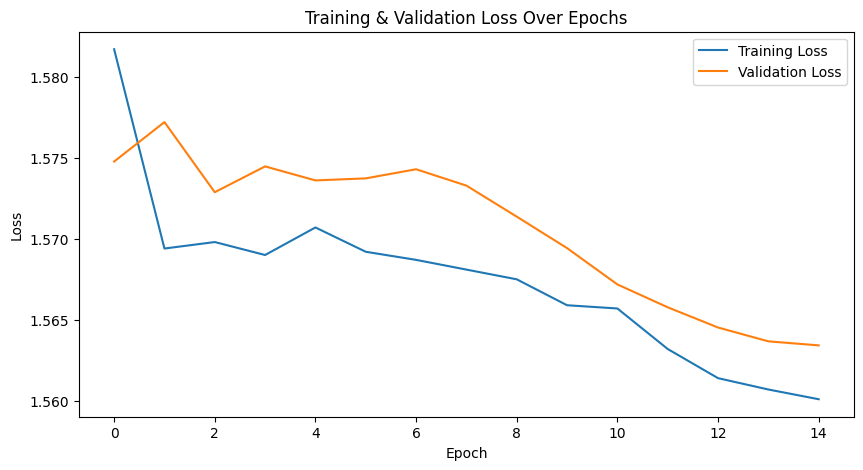

In [ ]:
import matplotlib.pyplot as plt

# Access and plot training and validation losses
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Print evaluation results
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 1.570197343826294, 'eval_accuracy': 0.28054298642533937, 'eval_runtime': 0.5765, 'eval_samples_per_second': 3833.613, 'eval_steps_per_second': 60.713, 'epoch': 15.0}


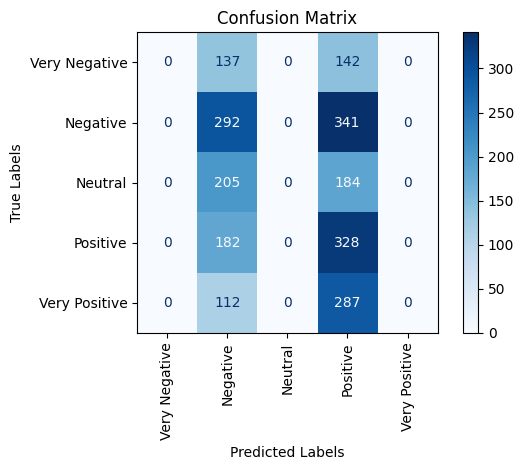

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=1)  # Get the predicted class
labels = predictions.label_ids                  # True labels

# Define label names for SST-5
label_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

# Compute the confusion matrix
cm = confusion_matrix(labels, preds)

# Create a display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

# Show the plot
plt.show()

### FULL DISTILBERT with LoRA

In [ ]:
# Load the DistilBERT model for sequence classification
base_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

print(base_model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Define LoRA configuration with the correct target modules
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,       # Sequence Classification task
    inference_mode=False,            # Training mode
    r=8,                             # Low-rank dimension
    lora_alpha=16,                   # Scaling factor
    lora_dropout=0.1,                # Dropout probability for LoRA layers
    target_modules=["q_lin", "v_lin"]  # Correct target modules
)

# Apply LoRA to the base model
model = get_peft_model(base_model, lora_config)

In [ ]:
# Check trainable parameters
model.print_trainable_parameters()

trainable params: 741,893 || all params: 67,699,210 || trainable%: 1.0959


In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=600,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=steps_per_epoch,  # Ensures it logs at the end of each epoch
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    learning_rate=3e-5,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.545000,1.322925,0.407811
2,1.242300,1.216085,0.450500
3,1.190000,1.181970,0.475931
4,1.158900,1.178864,0.477748
5,1.140800,1.189109,0.452316
6,1.129700,1.173694,0.484105
7,1.118700,1.173570,0.474114
8,1.112800,1.179765,0.463215
9,1.101100,1.164386,0.483197
10,1.096900,1.159104,0.485922


TrainOutput(global_step=8010, training_loss=1.149332773730103, metrics={'train_runtime': 1045.4408, 'train_samples_per_second': 122.589, 'train_steps_per_second': 7.662, 'total_flos': 4317504737034240.0, 'train_loss': 1.149332773730103, 'epoch': 15.0})

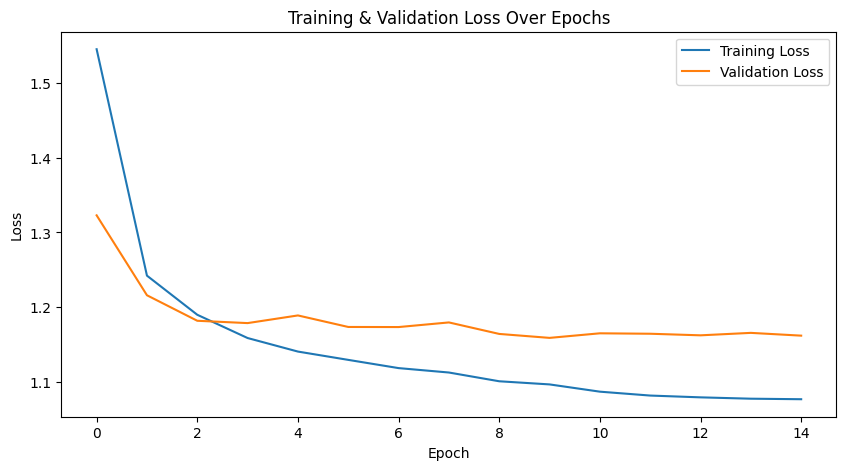

In [ ]:
import matplotlib.pyplot as plt

# Access and plot training and validation losses
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Print evaluation results
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 1.11032235622406, 'eval_accuracy': 0.5054298642533936, 'eval_runtime': 7.8657, 'eval_samples_per_second': 280.966, 'eval_steps_per_second': 4.45, 'epoch': 15.0}


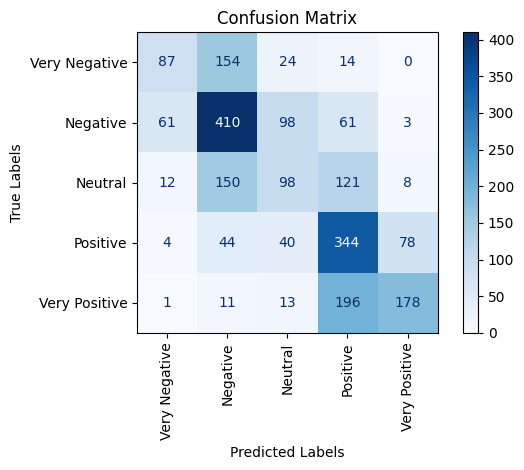

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=1)  # Get the predicted class
labels = predictions.label_ids                  # True labels

# Define label names for SST-5
label_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

# Compute the confusion matrix
cm = confusion_matrix(labels, preds)

# Create a display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

# Show the plot
plt.show()

### check the dataset

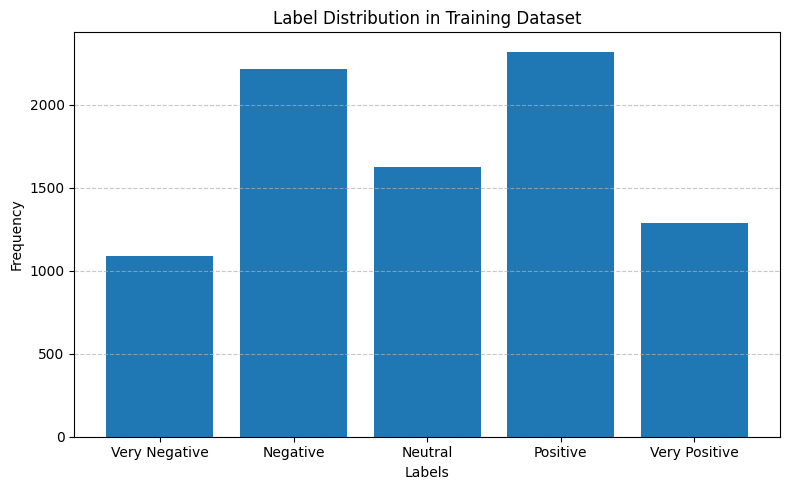

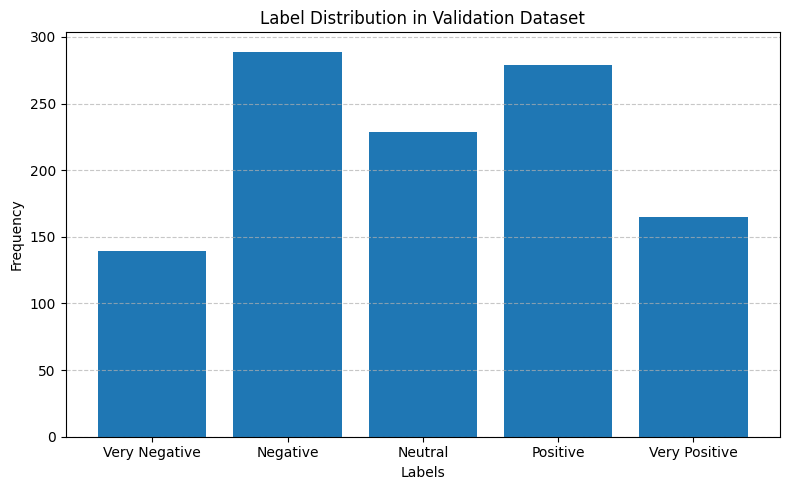

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(dataset, split_name):
    """
    Plot label distribution for a given dataset split.
    """
    # Extract labels
    labels = [example['label'] for example in dataset]

    # Count frequency of each label
    label_counts = Counter(labels)

    # Sort labels and counts
    sorted_labels = sorted(label_counts.keys())
    frequencies = [label_counts[label] for label in sorted_labels]

    # Define label names for SST-5
    label_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(sorted_labels, frequencies, tick_label=[label_names[i] for i in sorted_labels])
    plt.title(f"Label Distribution in {split_name} Dataset")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Check training set
plot_label_distribution(dataset['train'], "Training")

# Check validation set
plot_label_distribution(dataset['validation'], "Validation")
